In [718]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from scipy.optimize import curve_fit

In [309]:
from resonator_tools.circuit import notch_port, reflection_port
from resonator_tools import calibration

# Resonator 

$$
S_{21} = 1-(1-A)\cdot e^{i\cdot\varphi+\alpha}
$$

In [627]:
def db2mag(db): return np.power(10, db/20) # !^3*12$

def set_power_scan(pows_exper, mag, pha): 
    #normalization 

    mag_m1colomn = mag-mag[:,0][np.newaxis].T  #  mag_m1colomn: (4001, 102)
    mag_db = db2mag(mag_m1colomn)              #        mag_db: (4001, 102)
    S21_abs = mag_db[:,1:]                     #       S21_abs: (4001, 101)

    pha_m1colomn = pha-pha[:,0][np.newaxis].T   # pha_m1colomn: (4001, 102)
    phi_raw = pha_m1colomn[:,1:]                # phi_raw: (4001, 101)
    S21_phi = np.angle(np.exp(1j*phi_raw))      # smoothing out phase jumps

    powers = pows_exper[1:]                     # powers: (101,)
    return S21_abs, S21_phi, powers

C:\Users\mukha\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


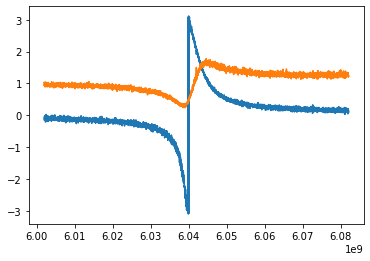

In [273]:
# adress_file = r"C:\Users\mukha\Downloads\Gain_12.084202104232356GHz.mat"  #1
# adress_file = r"C:\Users\mukha\Documents\Aalto\Data\Resonators\Gain_12.084202104232356GHz(2).mat"  # 2 good
adress_file = r"C:\Users\mukha\Documents\Aalto\Data\Resonators\Gain_12.084202104240102GHz.mat" 


mat = scipy.io.loadmat(adress_file)
freqs, mag, pha, Gain, pows_exper = np.array(mat['f'][0]),  np.array(mat['mag']),  np.array(mat['pha']),  np.array(mat['Gain']), np.array(mat['SignalGeneratorPumpP'][0])

S21_abs, S21_phi, powers = set_power_scan(pows_exper, mag, pha) 

S21 = S21_abs*np.exp(1j*S21_phi)

plt.plot(freqs, S21_phi[:,1])
plt.plot(freqs, S21_abs[:,1])

0


C:\Users\mukha\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


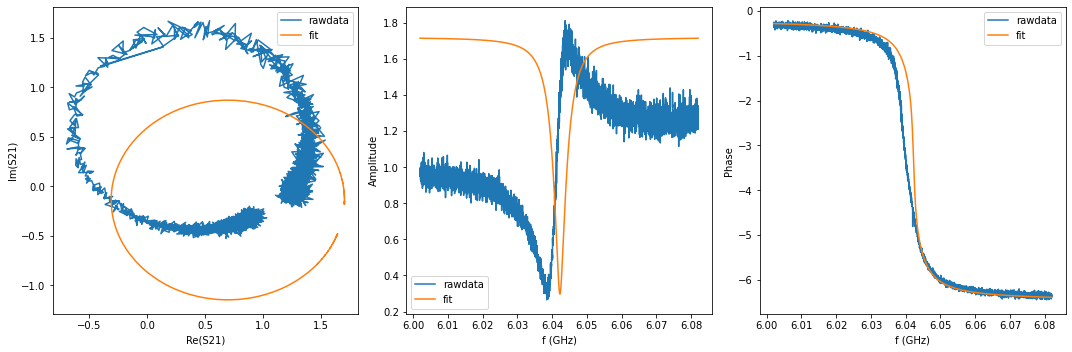

In [271]:
tre = 0
tim = 0
S21 = S21_abs*np.exp(1j*S21_phi)
print(tim)
port2 = reflection_port()  #define a reflection port
port2.add_data(freqs, S21[:,3])
port2.autofit(electric_delay=100)
port2.plotall()

C:\Users\mukha\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


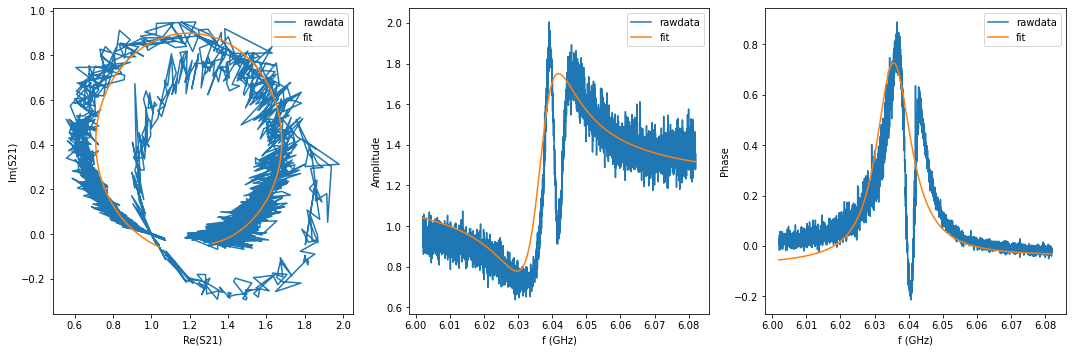

In [204]:
port1 = notch_port(freqs[:], S21[:,1])
port1.autofit()
port1.plotall()

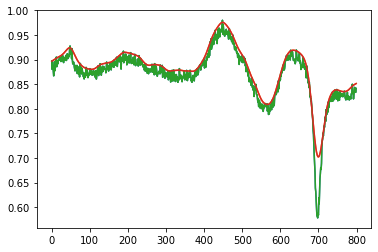

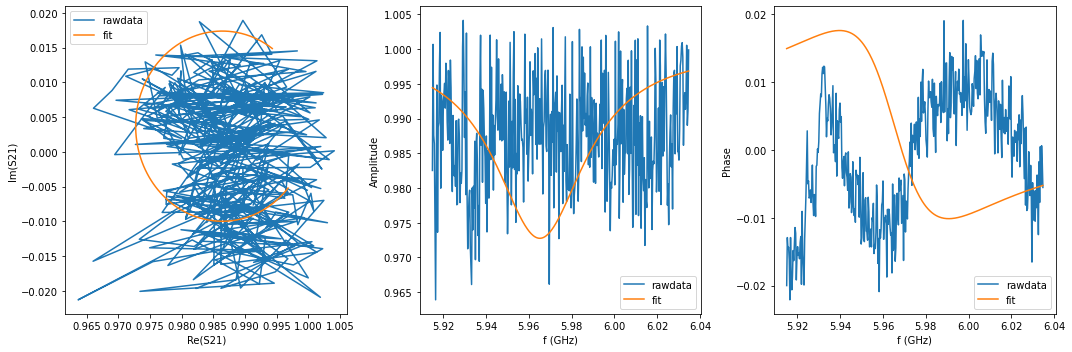

In [605]:
adress_file = r"C:\Users\mukha\Documents\Aalto\Data\Resonators\M_res_1.mat" 
mat = scipy.io.loadmat(adress_file)

power = 0
freqs, mag1, pha = np.array(mat['f'][0]),  np.array(mat['mag2']),  np.array(mat['pha2'])

mag = np.power(10, mag1/10)

S21 = (mag)*np.exp(1j*pha)

start = 1050
stop = 1850

f = freqs[start:stop]
S = S21[start:stop,3]

port2.add_data(f,S)
# port2.plotrawdata()

lam = 1e2#smoothness
p = 0.99  #asymmetry

fitted_baseline = port2.fit_baseline_amp(port2.z_data_raw,lam,p,niter=10)
plt.plot(np.absolute(port2.z_data_raw))
plt.plot(fitted_baseline)

base_correct = 1
plt.plot(np.absolute(port2.z_data_raw))
plt.plot(fitted_baseline*base_correct)

start1 = 0
stop1 = 400

port3 = reflection_port() 
port3.add_data(f[start1:stop1],(S/(fitted_baseline*base_correct))[start1:stop1])
port3.autofit(electric_delay=0.)
port3.plotall()

# port2 = reflection_port()  #define a reflection port
# port2.add_data(freqs[start:], S21[start:,3])
# port2.autofit(electric_delay=100)
# port2.plotall()

[6.04288157e+00 7.51301321e-07 1.00671156e+01 1.07622859e+00]
[6.03703749e+00 2.03335132e-02 1.17265783e-02 4.81373516e+06]


C:\Users\mukha\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


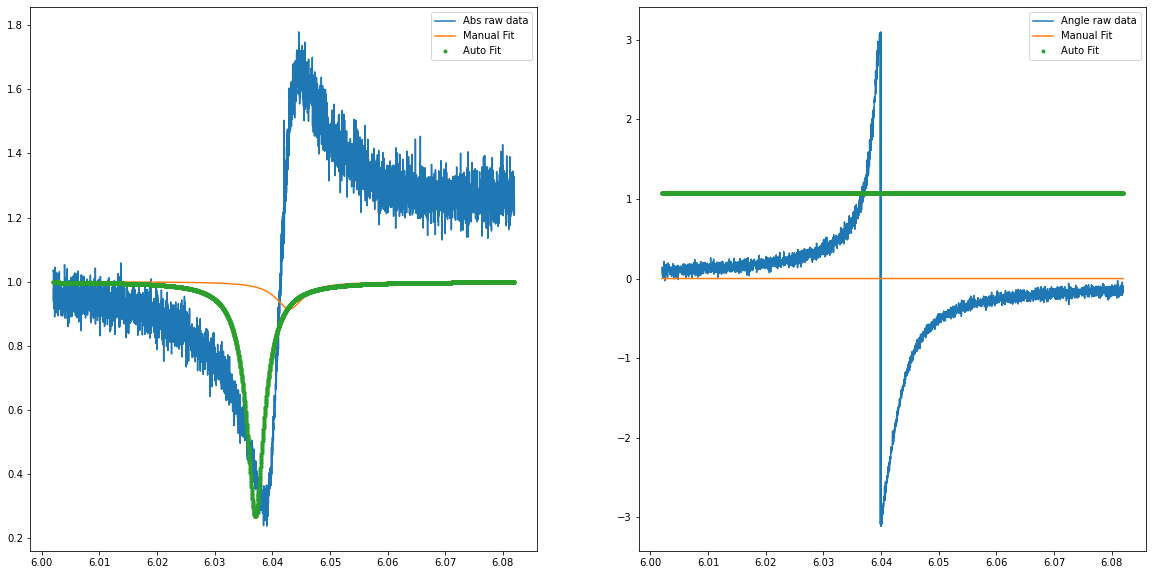

In [846]:
adress_file = r"C:\Users\mukha\Documents\Aalto\Data\Resonators\Gain_12.084202104240102GHz.mat" 


mat = scipy.io.loadmat(adress_file)
freqs, mag, pha, Gain, pows_exper = np.array(mat['f'][0]),  np.array(mat['mag']),  np.array(mat['pha']),  np.array(mat['Gain']), np.array(mat['SignalGeneratorPumpP'][0])

S21_abs, S21_phi, powers = set_power_scan(pows_exper, mag, pha) 

S21 = S21_abs*np.exp(1j*S21_phi+0.25)

freqs = freqs/1e9

def fit_S21_why(f, fr, a, phi, Ql, Qc, alpha):
    E3 = np.exp(1j*phi)
    E2 = np.exp(-1j*alpha)
    Ch = Ql/np.abs(Qc)*E3
    Zn = 1+2*1j*Ql*(f/fr-1)
    return a*(1-Ch/Zn)*E2

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(freqs, S21_abs[:,1], label = 'Abs raw data')
ax2.plot(freqs, S21_phi[:,1], label = 'Angle raw data')

fres = 6.04298
k = 3.6*1e-2
g = 0.16*1e-2
T = -0.23


def fit1(f, fr, kappa, gamma, tau):
    return np.abs((1-np.abs(kappa)/(-1j*2*np.pi*(f-fr)+ (kappa+gamma)/2))*np.exp(1j*tau))

def fit2(f, fr, kappa, gamma, tau):
    return np.angle((1-np.abs(kappa)/(-1j*2*np.pi*(f-fr)+ (kappa+gamma)/2))*np.exp(1j*tau))


ax1.plot(freqs, np.abs(fit1(freqs, fr=fres, kappa=k, gamma=g, tau=T)), 
        label = 'Manual Fit')
ax2.plot(freqs, np.angle(fit1(freqs, fr=fres, kappa=k, gamma=g, tau=T)), 
        label = 'Manual Fit')


popt1, pcov1 = curve_fit(fit2, freqs, S21_abs[:,1], p0=[fres, k, g, T])
ax2.plot(freqs, fit2(freqs, *popt1), ".", label = 'Auto Fit')
print(popt1)

popt, pcov = curve_fit(fit1, freqs, S21_abs[:,1], p0=[fres, k, g, T])
ax1.plot(freqs, fit1(freqs, *popt),".", label = 'Auto Fit')
print(popt)

    
ax1.legend()
ax2.legend()

6.041997437443156
0.03302580228641423 -0.000331779848115078
0.005856604628144175 -0.0010322002963140326
0.6813110872448546


C:\Users\mukha\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


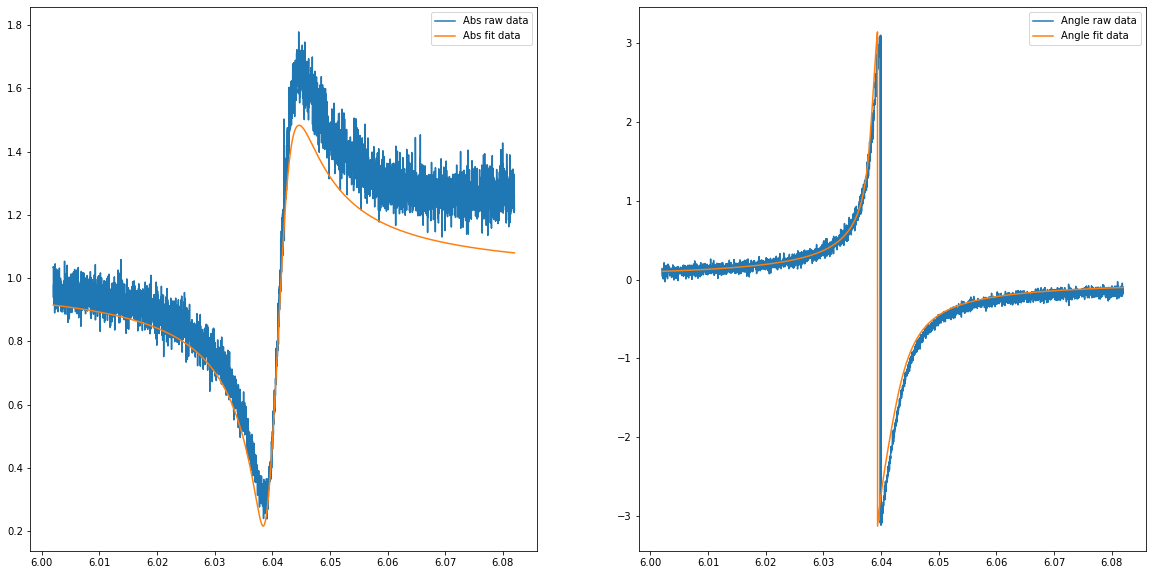

In [911]:
adress_file = r"C:\Users\mukha\Documents\Aalto\Data\Resonators\Gain_12.084202104240102GHz.mat" 
mat = scipy.io.loadmat(adress_file)
freqs, mag, pha, Gain, pows_exper = np.array(mat['f'][0]),  np.array(mat['mag']),  np.array(mat['pha']),  np.array(mat['Gain']), np.array(mat['SignalGeneratorPumpP'][0])
S21_abs, S21_phi, powers = set_power_scan(pows_exper, mag, pha) 

S21 = S21_abs*np.exp(1j*S21_phi)


freqs = freqs/1e9

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(freqs, S21_abs[:,1], label = 'Abs raw data')
ax2.plot(freqs, S21_phi[:,1], label = 'Angle raw data')


fres = 6.042
k_re = 0.033
k_im = -0.0003
g_re = 0.0058
g_im = -0.001
T = 0.68

def partF(f, fr, ka_re, ka_im, ga_re, ga_im, tau):
    return (1-np.abs(ka_re+1j*ka_im)*np.exp(1j*tau)/(-1j*2*np.pi*(f-fr)+ (ka_re+1j*ka_im+ga_re+1j*ga_im)/2))


def funcBoth(f, fr, ka_re, ka_im, ga_re, ga_im, tau):
    N = len(f)
    f = f[:N//2]
    S = (1-np.abs(ka_re+1j*ka_im)*np.exp(1j*tau)/(-1j*2*np.pi*(f-fr)+ (ka_re+1j*ka_im+ga_re+1j*ga_im)/2))
    return np.hstack([np.abs(S), np.angle(S)])

yBoth = np.hstack([S21_abs[:,1], S21_phi[:,1]])
xBoth = np.hstack([freqs, freqs])
poptBoth, pcovBoth = curve_fit(funcBoth, xBoth, yBoth, p0=[fres, k_re, k_im, g_re, g_im, T])

S12_abs_fit = np.abs(partF(freqs, *poptBoth))
S12_angle_fit = np.angle(partF(freqs, *poptBoth))

ax1.plot(freqs, S12_abs_fit, label = 'Abs fit data')
ax2.plot(freqs, S12_angle_fit, label = 'Angle fit data')

print(poptBoth[0])
print(poptBoth[1], poptBoth[2])
print(poptBoth[3], poptBoth[4])
print(poptBoth[5])

ax1.legend()
ax2.legend()

C:\Users\mukha\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


0.033644731849422085 -0.0006240015616283444
0.004374883479518387 -0.0013035677888664431


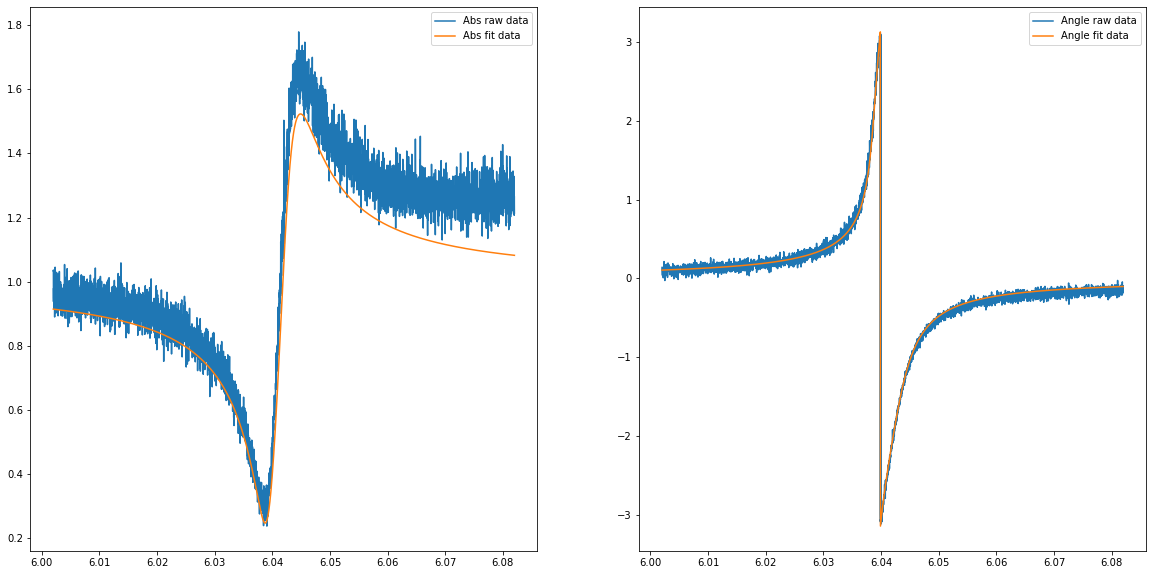

In [919]:
adress_file = r"C:\Users\mukha\Documents\Aalto\Data\Resonators\Gain_12.084202104240102GHz.mat" 
mat = scipy.io.loadmat(adress_file)
freqs, mag, pha, Gain, pows_exper = np.array(mat['f'][0]),  np.array(mat['mag']),  np.array(mat['pha']),  np.array(mat['Gain']), np.array(mat['SignalGeneratorPumpP'][0])
S21_abs, S21_phi, powers = set_power_scan(pows_exper, mag, pha) 

S21 = S21_abs*np.exp(1j*S21_phi)


freqs = freqs/1e9

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(freqs, S21_abs[:,1], label = 'Abs raw data')
ax2.plot(freqs, S21_phi[:,1], label = 'Angle raw data')


fres = 6.0425
k_re = 0.033
k_im = -0.0003
g_re = 0.0058
g_im = -0.001
T = 0.68

def partF(f, ka_re, ka_im, ga_re, ga_im):
    return (1-np.abs(ka_re+1j*ka_im)*np.exp(1j*T)/(-1j*2*np.pi*(f-fres)+ (ka_re+1j*ka_im+ga_re+1j*ga_im)/2))


def funcBoth(f, ka_re, ka_im, ga_re, ga_im):
    N = len(f)
    f = f[:N//2]
    S = (1-np.abs(ka_re+1j*ka_im)*np.exp(1j*T)/(-1j*2*np.pi*(f-fres)+ (ka_re+1j*ka_im+ga_re+1j*ga_im)/2))
    return np.hstack([np.abs(S), np.angle(S)])

yBoth = np.hstack([S21_abs[:,1], S21_phi[:,1]])
xBoth = np.hstack([freqs, freqs])
poptBoth, pcovBoth = curve_fit(funcBoth, xBoth, yBoth, p0=[k_re, k_im, g_re, g_im])

S12_abs_fit = np.abs(partF(freqs, *poptBoth))
S12_angle_fit = np.angle(partF(freqs, *poptBoth))

ax1.plot(freqs, S12_abs_fit, label = 'Abs fit data')
ax2.plot(freqs, S12_angle_fit, label = 'Angle fit data')


print(poptBoth[0], poptBoth[1])
print(poptBoth[2], poptBoth[3])


ax1.legend()
ax2.legend()

In [705]:
power = 0
scan = scan_areas[0]

NameError: name 'scan_areas' is not defined

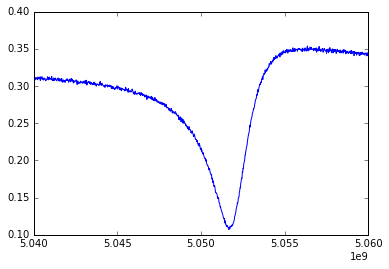

In [8]:
freqs, S21s = power_scans[scan][power][0], power_scans[scan][power][1]
plt.plot(freqs, abs(S21s))

In [9]:
resonators_data = []
sim_S21s = []
for scan in scan_areas[1:]:
    Qls = []
    Qis = []
    Qes = []
    frs = []
    for power in range(len(powers)):
        freqs, S21s = power_scans[scan][power][0], power_scans[scan][power][1]
        np = notch_port(freqs, S21s)
        np.autofit()
        if (np.fitresults["Qi_dia_corr"]<10e5 and np.fitresults["Qi_dia_corr"]>10e2) or len(Qls)==0:
            Qls.append(np.fitresults["Ql"])
            Qes.append(np.fitresults["Qc_dia_corr"])
            Qis.append(np.fitresults["Qi_dia_corr"])
        else:
            Qls.append(Qls[-1])
            Qes.append(Qes[-1])
            Qis.append(Qis[-1])
            frs.append(frs[-1])
            continue
        if abs(np.fitresults["fr"]) <1e10 or len(frs)==0:
            frs.append(np.fitresults["fr"])
        else:
            frs.append(frs[-1])
    resonators_data.append((Qls, Qis, Qes, frs))
    sim_S21s.append(np.z_data_sim)

/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


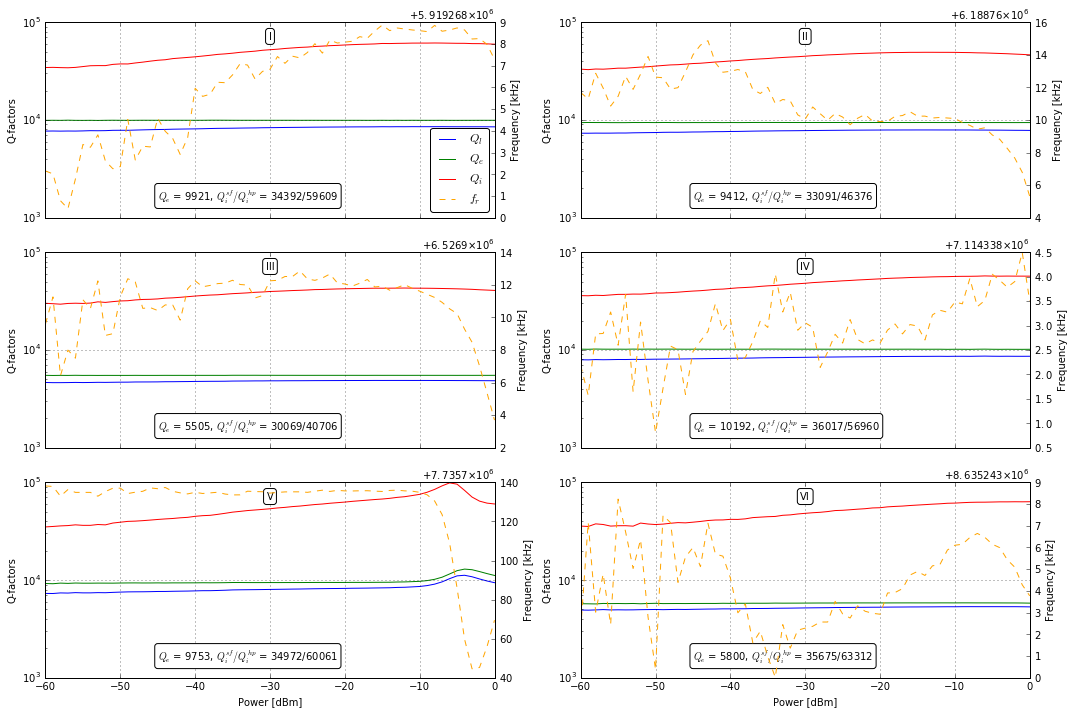

In [12]:
fig, axes = plt.subplots(3, 2, figsize = (15, 10), sharex = True)
greek_nums = ["I", "II", "III", "IV", "V", "VI", "VII"]
for idx, ax in list(enumerate(flatten(axes)))[:]:
    Qls, Qis, Qes, frs = resonators_data[idx]
    lns = ax.plot(powers, Qls, label = "$Q_l$")
    lns += ax.plot(powers, Qes, label = "$Q_e$")
    lns += ax.plot(powers, Qis, label = "$Q_i$")
#     spines(ax)

    ax.set_yscale("log")
    ax.set_ylabel("Q-factors")
    ax.set_ylim(1e3, 1e5)
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    
    ax.text(-30, ax.get_ylim()[1]/1.5, greek_nums[idx], bbox=props, horizontalalignment="center")
    ax.text(-45, ax.get_ylim()[0]*1.5, "$Q_e$ = %i"%mean(Qes)+
            ", $Q_i^{sf}/Q_i^{hp}$ = %i/%i"%(Qis[0], Qis[-1]), bbox=props)
    
    if idx>3:
        ax.set_xlabel("Power [dBm]")
    ax.grid()
    
    ax2 = ax.twinx()
#     spines(ax2)

    lns += ax2.plot(powers, array(frs)/1e3, "--", label = '$f_r$', color="orange")
    y_formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    ax2.yaxis.set_major_formatter(y_formatter)
    ax2.set_ylabel("Frequency [kHz]")
#     ax2.yaxis.get_offset_text().set_y(1.5)

axes[0][0].legend(lns, [ln.get_label() for ln in lns], loc=4, framealpha=1, fancybox=True)
    
plt.tight_layout()
plt.savefig("/home/gleb/Документы/Science/Reverse engineering of XMons/Resonators/Pictures/q-factors-and-freqs_al_bad.pdf",
            bbox_inches="tight")

In [45]:
font = {"size":12}
matplotlib.rc("font", **font)

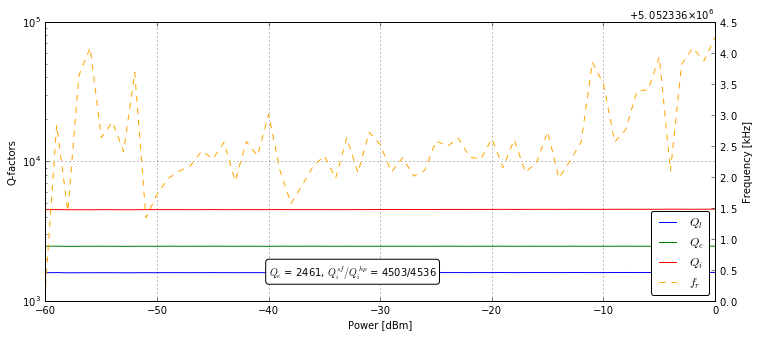

In [6]:
Qls, Qis, Qes, frs = resonators_data[0]
lns = plt.plot(powers, Qls, label = "$Q_l$")
lns += plt.plot(powers, Qes, label = "$Q_e$")
lns += plt.plot(powers, Qis, label = "$Q_i$")

plt.gca().set_yscale("log")
plt.gca().set_ylabel("Q-factors")
plt.gca().set_ylim(1e3, 1e5)
props = dict(boxstyle='round', facecolor='white', alpha=1)

plt.gca().text(-40, plt.gca().get_ylim()[0]*1.5, "$Q_e$ = %i"%mean(Qes)+
        ", $Q_i^{sf}/Q_i^{hp}$ = %i/%i"%(Qis[0], Qis[-1]), bbox=props)

plt.gca().set_xlabel("Power [dBm]")
plt.grid()

ax2 = plt.gca().twinx()
#     spines(ax2)

lns += ax2.plot(powers, array(frs)/1e3, "--", label = '$f_r$', color="orange")
y_formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
ax2.yaxis.set_major_formatter(y_formatter)
ax2.set_ylabel("Frequency [kHz]")
plt.gcf().set_size_inches(12,5)
plt.legend(lns, [ln.get_label() for ln in lns], loc=0, framealpha=1, fancybox=True)

plt.savefig("/home/gleb/Документы/Science/Reverse engineering of XMons/Resonators/Pictures/spurious_al.pdf",
            bbox_inches="tight")

In [53]:
power = 20
scan = scan_areas[1]
freqs, S21s = power_scans[scan][power][0], power_scans[scan][power][1]
np = notch_port(freqs, S21s)
np.autofit()

/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/gleb/.ENV/lib/python3.4/site-packages/resonator_tools-0.1-py3.4.egg/resonator_tools/circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [42]:
np.fitresults

{'Qc_dia_corr': 15596.408151736494,
 'Qi_dia_corr': 30481.894494477398,
 'Qi_dia_corr_err': 939.83665301548581,
 'Qi_no_corr': 42734.030470262733,
 'Qi_no_corr_err': 1806.5035289600967,
 'Ql': 10317.395400264419,
 'Ql_err': 111.59567066229715,
 'absQc': 13601.161516505026,
 'absQc_err': 50.255098325209666,
 'chi_square': 0.00071058843189953345,
 'fr': 5315295661.2344532,
 'fr_err': 2685.4654790792579,
 'phi0': 0.51137974048406321,
 'phi0_err': 0.0099063413806078204,
 'theta0': -2.6302152263834642}

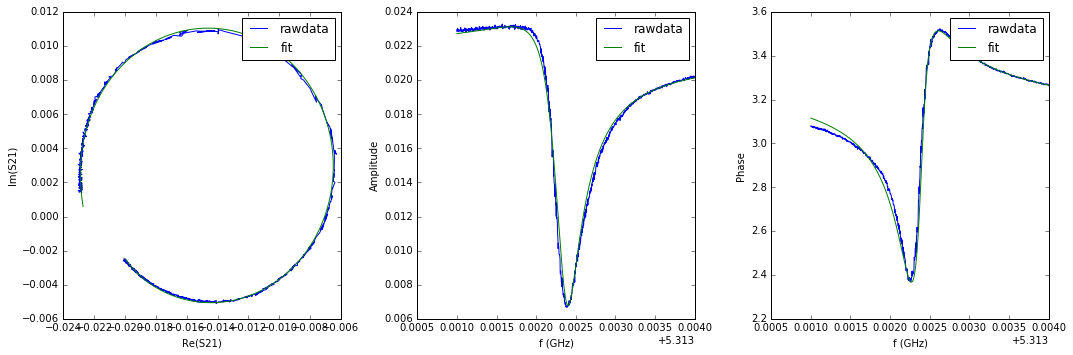

In [43]:
np.plotall()

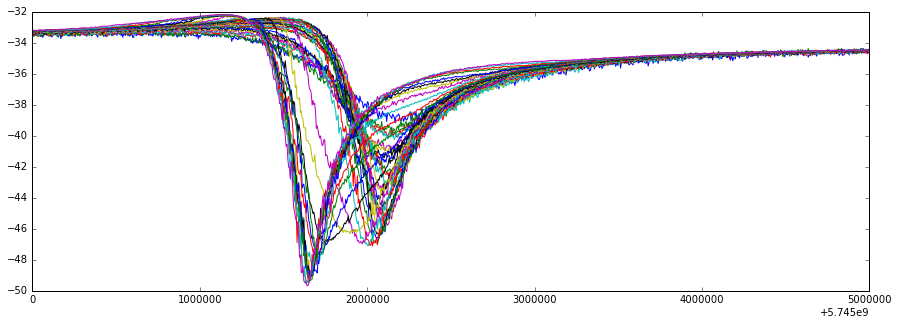

In [56]:
for power in range(0, 40):
    plt.plot(power_scans[scan][power][0], 20*log10(abs(power_scans[scan][power][1])))
plt.gcf().set_size_inches(15,5)